In [1]:
import time
start_time=time.time()

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import strucfunc
from strucfunc import sosflog
from bfunc import bfunc00,bfunc01,bfunc02

In [3]:
name = 'HV'

In [4]:
pickle_in = open('VFM//' + name + '.pkl',"rb")
data = pickle.load(pickle_in)
sb = data['sb']
vv = data['vv']
#ss = data['ss']

In [5]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
#ss[m] = 0.0
sb /= sb.max()

good = (~m) & (sb > 0.001)

<ipython-input-5-d54fa62d4697>:2: RuntimeWarning: invalid value encountered in less
  m = ~np.isfinite(sb*vv) | (sb < 0.0)


In [6]:
rslt = strucfunc.strucfunc_numba_parallel(data['vv'], wmap=data['sb'], dlogr=0.15)

In [7]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [8]:
b2 = rslt['Unweighted B(r)']
e_b2 = b2  *.1
s = 10**rslt['log10 r'] * data['pix'] * data['pc']
e_s = s  *.1
sig2 = rslt['Unweighted sigma^2']
sig = sig2**0.5

In [9]:
#r0 = np.interp(sig2, b2, s,period = 360)
#r0

In [10]:
x = s
y = b2 - sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
r0 = SFr[0]

In [11]:
r1 = np.interp(sig, b2, s,period = 360)
r1

1.0702230820834315

In [12]:
r2 = np.interp(2*sig2, b2, s, period = 360)
r2

12.06162715976092

In [13]:
m = 1.5

(7.864699245044958, 2.7246536445912195, 1.5)

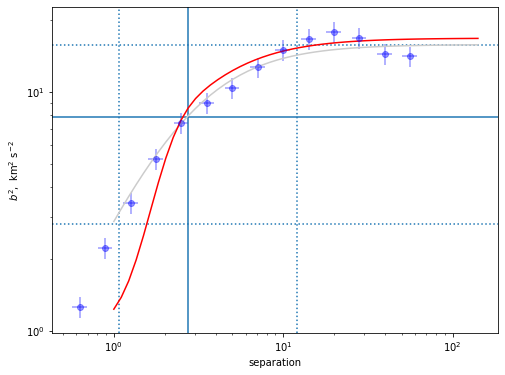

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
rgrid = np.logspace(0, 2.15)
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.4,color="blue")


ax.axhline(sig2, ls='-')
ax.axvline(r0, ls='-')

ax.axhline(2*sig2, ls=':')
ax.axvline(r2, ls=':')

ax.axhline(sig, ls=':')
ax.axvline(r1, ls=':')

ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, data['s0'], 1.0), color="red")

ax.set(xscale='log', yscale='log', 
       xlabel='separation',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

sig2, r0, m

In [15]:
rslt

{'log10 r': array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95]),
 'Sum dv^2': array([6.89789180e+03, 2.42380623e+04, 9.30458441e+04, 3.07191105e+05,
        9.32696215e+05, 2.09363674e+06, 5.00675486e+06, 1.08144170e+07,
        2.29401586e+07, 4.23652721e+07, 6.82177264e+07, 7.18341095e+07,
        3.61623971e+07, 4.28752532e+06]),
 'Sum weights': array([   321.37691939,    640.60909275,   1590.39403603,   3446.3217432 ,
          7298.87511122,  13229.00434465,  25967.87130549,  42032.6107859 ,
         65988.8076392 ,  93118.7562033 , 115960.91930306,  99592.41635161,
         50606.92885469,   5040.83226636]),
 'Sum w * dv^2': array([1.84785866e+02, 7.31735895e+02, 3.13401777e+03, 1.18037325e+04,
        4.05454735e+04, 1.06460712e+05, 2.88319075e+05, 6.04135038e+05,
        1.07174766e+06, 1.60630128e+06, 2.03622197e+06, 1.52652321e+06,
        7.09561116e+05, 9.07247542e+04]),
 'N pairs': array([   5505,   10962,   27191,   59011,  

In [16]:
N595 = { 'VF' : data,
        'SF' : rslt,
        's' : s,
        'b2' : b2,
        'sig2' : sig2,
        'pc' : data['pc'],
        'r0' : r0,
        'r1' : r1,
        'r2' : r2,
        's0' : data['s0'],
        'm' : m}

In [17]:
f = open('SFresults\\'+ name + '.pkl',"wb")
pickle.dump(N595,f)
f.close()

In [18]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 8.448791265487671 seconds ---
